# MNIST CNN Example

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


### Data Loader

In [2]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=test_transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Data Samples

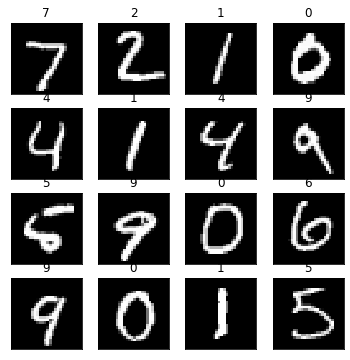

In [3]:
# Read from test loader
batch = next(iter(test_loader))
data, target = batch

# Convert tensor to numpy array
_data = data.data.cpu().numpy()
_target = target.data.cpu().numpy()

# Draw the samples
plt.figure(figsize=[6, 6])
for i in range(16):
    plt.subplot(4, 4, i+1)
    clazz = str(_target[i])
    plt.title(clazz)
    plt.imshow(_data[i][0], cmap='gist_gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


### Model

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(# (1, 28, 28) -> (32, 26, 26)
                                   nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
                                   nn.ReLU(),
                                   # -> (32, 13, 13)
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   # -> (64, 11, 11)
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                   nn.ReLU(),
                                   # -> (64, 5, 5)
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   # -> (64, 3, 3)
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                   nn.ReLU())
        
        self.linears = nn.Sequential(nn.Linear(in_features=64*3*3, out_features=64),
                                     nn.Tanh(),
                                     
                                     nn.Linear(in_features=64, out_features=10))
        
    def forward(self, x):
        '''
        x : [batch, channel=1, height=28, width=28]
        '''
        
        # [batch, channel, height, width]
        y = self.convs(x)
        # [batch, feature]
        y = torch.flatten(y, start_dim=1)
        # [batch, class=10]
        y = self.linears(y)
        
        return y
    
    def inference(self, x, test_num=100):
        ys = []
        for _ in range(test_num):
            # [batch, class]
            y = torch.softmax(self.forward(x), dim=1)
            ys.append(y)
        
        # [test_num, batch, class]
        ys = torch.stack(ys)
        
        return ys

### Model, Optimizer Initialization

In [5]:
model = Model().cuda()
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)
step = 0
epoch = 1

print('initialized')

Model(
  (convs): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (linears): Sequential(
    (0): Linear(in_features=576, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
initialized


### Train Step Function

In [6]:
def train_step(batch, model, optimizer):
    # Read x:image, t:target from batch
    x, t = batch
    
    # Upload the data to GPU memory
    x = x.cuda()
    t = t.cuda()
    
    # Initialize the all gradients in the model.
    model.zero_grad()
    
    # Input x:image to the model and get probabilities.
    y = model(x)
    
    # Compare the prediction with the truth.
    loss = nn.CrossEntropyLoss()(y, t)
    
    # Calculate the all gradients in the model.
    loss.backward()
    
    # Update the all weights in the model.
    optimizer.step()
    
    return loss

### Accuracy Test Function

In [7]:
def accuracy_test(loader, model):
    corrections = []
    for batch in loader:
        x, t = batch
        x = x.cuda()
        t = t.cuda()
        
        # (batch, class=10)
        y = model(x)
        
        # Choose a prediction from the probabilities by argmax (argument maximum) function
        # (batch)
        y = torch.argmax(y, dim=1)
        # (batch), boolean array
        correction = (y == t)
        corrections.append(correction)

    corrections = torch.cat(corrections)
    accuracy = (torch.sum(corrections).float() / len(corrections)).item()
    
    return accuracy

### Train Loop

In [8]:
from IPython import display
import matplotlib.pyplot as plt

model.train()

while(True):
    
    for batch in train_loader:
        loss = train_step(batch, model, optimizer)
        
        if step % 100 == 0:
            print('step :', step, 'loss :', '%0.4f' % loss.item())
        step += 1    
        
    # After training one epoch, evaluate the test data and estimate the accuracy.
    accuracy = accuracy_test(test_loader, model)
    display.clear_output()
    print('=== epoch :', epoch, 'accuracy :', '%0.4f' % accuracy, '===')
    
    epoch += 1
    
    # Loop until epoch > 5
    if epoch > 5:
        break
        

=== epoch : 5 accuracy : 0.9903 ===


### Test

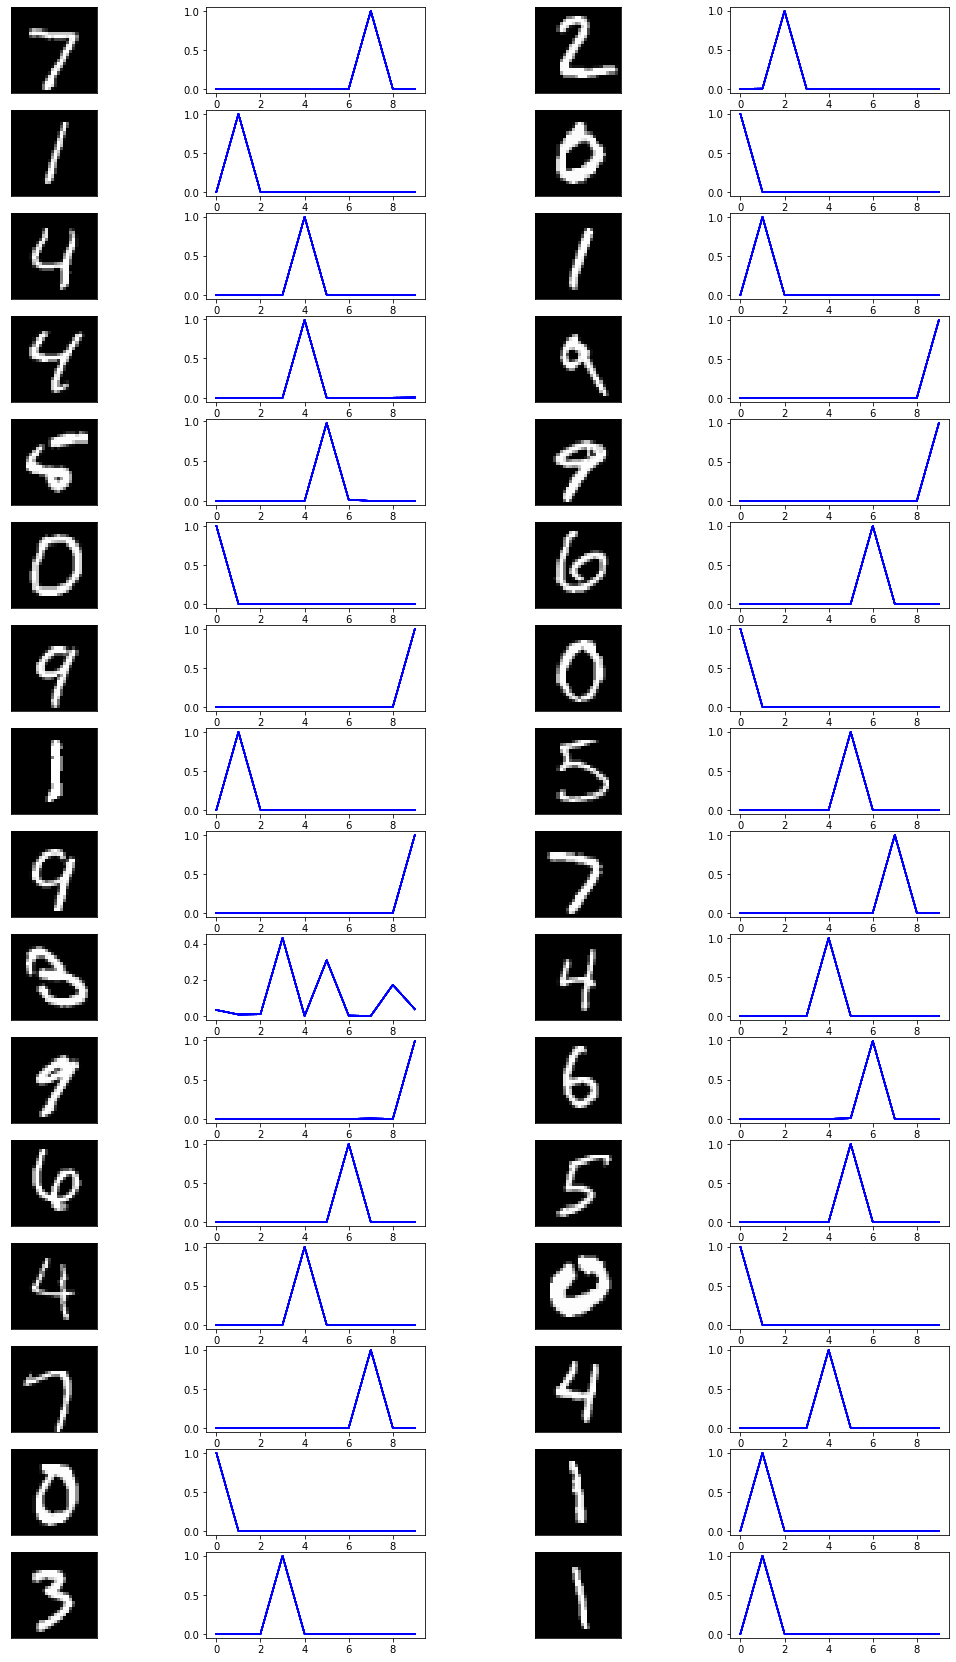

In [9]:
test_num = 100
batch = next(iter(test_loader))
x, t = batch
ys = model.inference(x.cuda(), test_num=test_num)

_x = x.data.cpu().numpy()
_ys = ys.data.cpu().numpy()

plt.figure(figsize=[18, 30])
for i in range(32):
    plt.subplot(16, 4, i*2+1)
    plt.imshow(_x[i, 0], cmap='gist_gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(16, 4, i*2+2)
    for j in range(test_num):
        plt.plot(_ys[j, i], color='blue', alpha=0.1)
plt.show()
